In [1]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss

# магия для того, чтобы графики рисовались в векторном формате
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')


# import aesara.tensor as at
az.style.use("arviz-darkgrid")
# rng = np.random.default_rng(7)

### slot_138

In [2]:
from urllib.request import urlopen

data = np.zeros((138, 3), dtype=int)
with urlopen('https://stepik.org/media/attachments/lesson/1262145/slot_138.txt') as file:
    for i, line in enumerate(file.readlines()):
        data[i] = list(map(int, line.strip().split()))

In [3]:
table = {(0, 0, 0): 0,
 (0, 0, 1): 0,
 (0, 0, 2): 0,
 (0, 0, 3): 0,
 (0, 0, 4): 0,
 (0, 0, 5): 2,
 (0, 0, 6): 0,
 (0, 1, 1): 0,
 (0, 1, 2): 0,
 (0, 1, 3): 0,
 (0, 1, 4): 0,
 (0, 1, 5): 2,
 (0, 1, 6): 0,
 (0, 2, 2): 0,
 (0, 2, 3): 0,
 (0, 2, 4): 0,
 (0, 2, 5): 2,
 (0, 2, 6): 0,
 (0, 3, 3): 0,
 (0, 3, 4): 0,
 (0, 3, 5): 2,
 (0, 3, 6): 0,
 (0, 4, 4): 0,
 (0, 4, 5): 10,
 (0, 4, 6): 0,
 (0, 5, 5): 5,
 (0, 5, 6): 2,
 (0, 6, 6): 0,
 (1, 1, 1): 10,
 (1, 1, 2): 5,
 (1, 1, 3): 5,
 (1, 1, 4): 20,
 (1, 1, 5): 2,
 (1, 1, 6): 0,
 (1, 2, 2): 5,
 (1, 2, 3): 5,
 (1, 2, 4): 10,
 (1, 2, 5): 2,
 (1, 2, 6): 0,
 (1, 3, 3): 5,
 (1, 3, 4): 10,
 (1, 3, 5): 2,
 (1, 3, 6): 0,
 (1, 4, 4): 40,
 (1, 4, 5): 10,
 (1, 4, 6): 0,
 (1, 5, 5): 5,
 (1, 5, 6): 2,
 (1, 6, 6): 0,
 (2, 2, 2): 25,
 (2, 2, 3): 5,
 (2, 2, 4): 50,
 (2, 2, 5): 2,
 (2, 2, 6): 0,
 (2, 3, 3): 5,
 (2, 3, 4): 10,
 (2, 3, 5): 2,
 (2, 3, 6): 0,
 (2, 4, 4): 100,
 (2, 4, 5): 10,
 (2, 4, 6): 0,
 (2, 5, 5): 5,
 (2, 5, 6): 2,
 (2, 6, 6): 0,
 (3, 3, 3): 40,
 (3, 3, 4): 80,
 (3, 3, 5): 2,
 (3, 3, 6): 0,
 (3, 4, 4): 160,
 (3, 4, 5): 10,
 (3, 4, 6): 0,
 (3, 5, 5): 5,
 (3, 5, 6): 2,
 (3, 6, 6): 0,
 (4, 4, 4): 1000,
 (4, 4, 5): 40,
 (4, 4, 6): 320,
 (4, 5, 5): 20,
 (4, 5, 6): 10,
 (4, 6, 6): 160,
 (5, 5, 5): 10,
 (5, 5, 6): 5,
 (5, 6, 6): 2,
 (6, 6, 6): 80}

# Эмпирическое распределение выигрышей

In [4]:
rng = np.random.default_rng()  # эту штуку достаточно создать 1 раз
sample = rng.choice(data, size=len(data)) # эту штуку нужно повторить 10000 раз

In [5]:
rewards = np.array([
    table[tuple(sorted(s.tolist()))]
    for s in data
])

rewards.mean()

np.float64(0.38405797101449274)

In [6]:
num_of_trials = 10000

means = [
    rng.choice(rewards, size=len(data)).mean()
    for _ in range(num_of_trials)
]

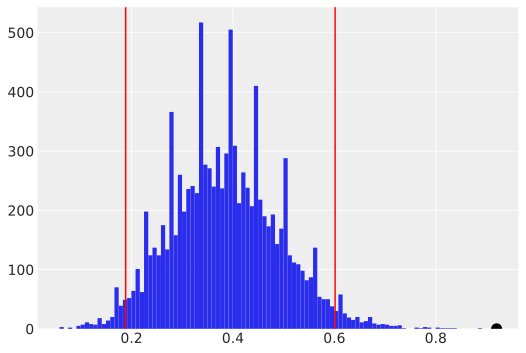

In [7]:
plt.hist(means, bins=100)

for q in np.quantile(means, [0.025, 0.975]):
    plt.axvline(x=q, color='red')

plt.scatter([0.92], [0], color='black', s=100)
plt.show()

# Вторая модель автомата

1. предположим, что окошки автомата независимы,
2. каждое отдельное окно приблизим его эмпирическим распределением.

## Распределение выборочных средних

In [8]:
sample = np.stack([rng.choice(data[:, i], size=(num_of_trials, len(data))) for i in range(3)], axis=1)
sample = sample.swapaxes(1, 2)
sample.shape

(10000, 138, 3)

In [9]:
means = []

for i in range(10000):
    means.append(
        sum(table[tuple(sorted(list(map(int, x))))] for x in sample[i]) / len(data)
    )

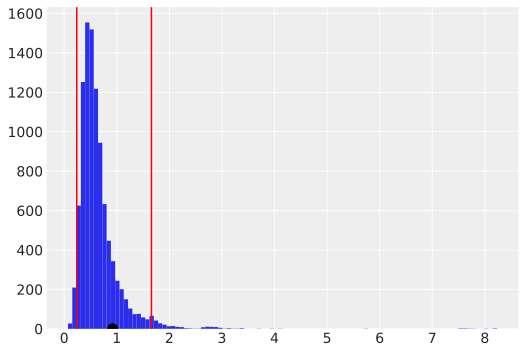

In [10]:
plt.hist(means, bins=100)

for q in np.quantile(means, [0.025, 0.975]):
    plt.axvline(x=q, color='red')


plt.scatter([0.92], [0], color='black', s=100)
plt.show()

## plug-in оценка матожидания

In [11]:
W = np.zeros((7, 7, 7))

for i in range(7):
    for j in range(7):
        for k in range(7):
            W[i, j, k] = table[tuple(sorted([i, j, k]))]

p0 = np.bincount(data[:, 0]) / len(data)
p1 = np.bincount(data[:, 1]) / len(data)
p2 = np.bincount(data[:, 2]) / len(data)

In [12]:
P = p0[:, None, None] * p1[None, :, None] * p2[None, None, :]

In [13]:
mean_reward = (W * P).sum()
mean_reward

np.float64(0.6479171803512233)

## Распределение plug-in оценок

In [14]:
sample = np.stack([rng.choice(data[:, i], size=(num_of_trials, len(data))) for i in range(3)], axis=1)
sample.shape

(10000, 3, 138)

In [15]:
means = []

W = np.zeros((7, 7, 7))

for i in range(7):
    for j in range(7):
        for k in range(7):
            W[i, j, k] = table[tuple(sorted([i, j, k]))]

for s in sample:
    s = s.swapaxes(0, 1)

    p0 = np.bincount(s[:, 0], minlength=7) / len(data)
    p1 = np.bincount(s[:, 1], minlength=7) / len(data)
    p2 = np.bincount(s[:, 2], minlength=7) / len(data)

    P = p0[:, None, None] * p1[None, :, None] * p2[None, None, :]

    mean_reward = (W * P).sum()
    means.append(mean_reward)

In [16]:
len(means)

10000

In [17]:
np.array(means).mean()

np.float64(0.648660733495886)

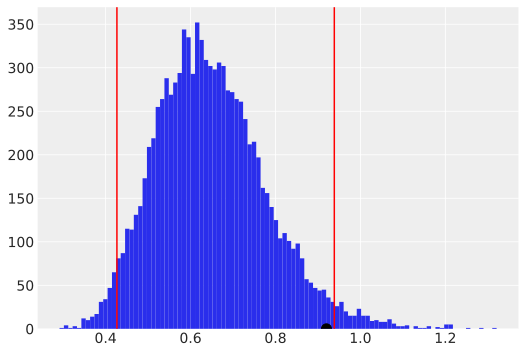

In [18]:
plt.hist(means, bins=100)

for q in np.quantile(means, [0.025, 0.975]):
    plt.axvline(x=q, color='red')

plt.scatter([0.92], [0], color='black', s=100)
plt.show()

In [19]:
np.quantile(means, [0.025, 0.975])

array([0.42662009, 0.93850926])

# Фитим с помощью PyMC

In [21]:
import pytensor.tensor as pt


with pm.Model() as slot_138:

  p = pm.Dirichlet('p', a = np.ones((3,7)))
  P = pm.Deterministic('P', ...)

  mean_reward = pm.Deterministic('mean_reward', ...)
  prior_mean_reward = pm.Potential('prior_mean_reward', pm.logp(pm.SomeThing.dist(...), mean_reward))

  # idata = pm.sample()


pm.model_to_graphviz(slot_138)

AttributeError: 'ellipsis' object has no attribute 'copy'

In [22]:
import pytensor.tensor as pt


with pm.Model() as model:

  p = pm.Dirichlet('p', a = np.ones((3,7)))
  P = pm.Deterministic('P', ...)

  mean_reward = pm.Deterministic('mean_reward', ...)
  prior_mean_reward = pm.Potential('prior_mean_reward', pm.logp(pm.SomeThing.dist(...), mean_reward))
  slot = pm.Categorical('slot', p = p, observed=data)

  # trace = pm.sample()


pm.model_to_graphviz(model)

AttributeError: 'ellipsis' object has no attribute 'copy'